In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


cuda
(120624, 512, 1)
(120624,)
总数据维度为： (120624, 1, 512)
总标签维度为： (120624,)
(96499, 1, 512)
(24125, 1, 512)
RSNet(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (shrinkage): Shrinkage(
        (gap): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=64, out_features=64, bias=True)
          (4): Sigmoid()
        )
      )
      (residual_function): Sequential(
        (0): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

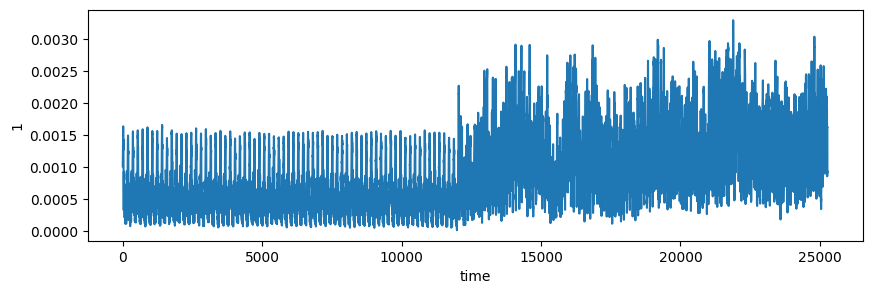

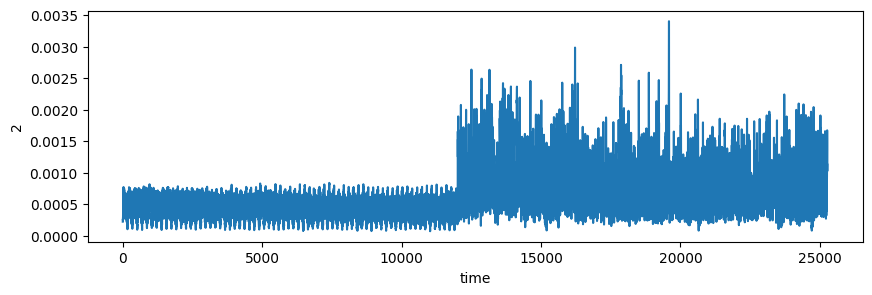

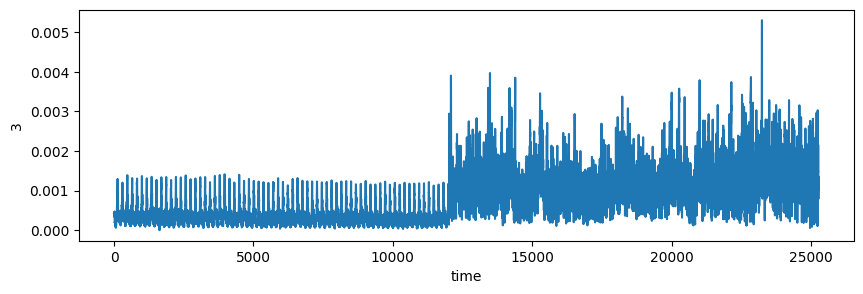

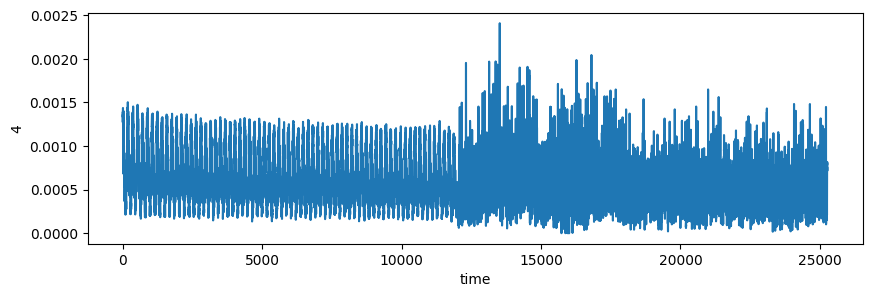

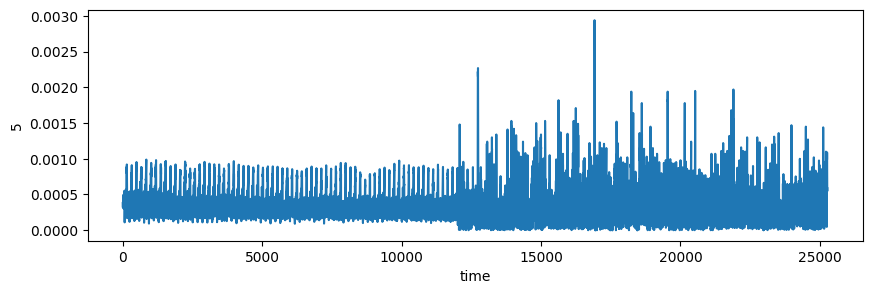

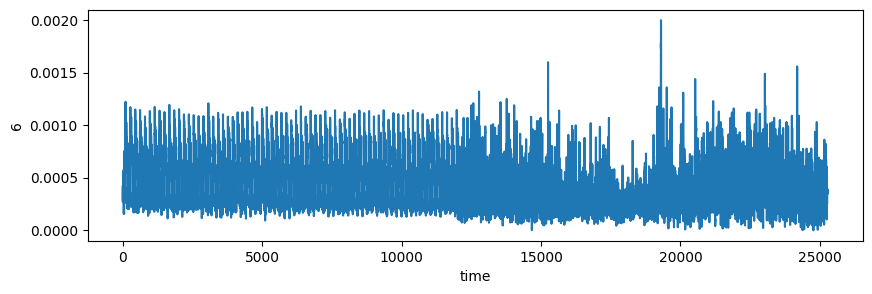

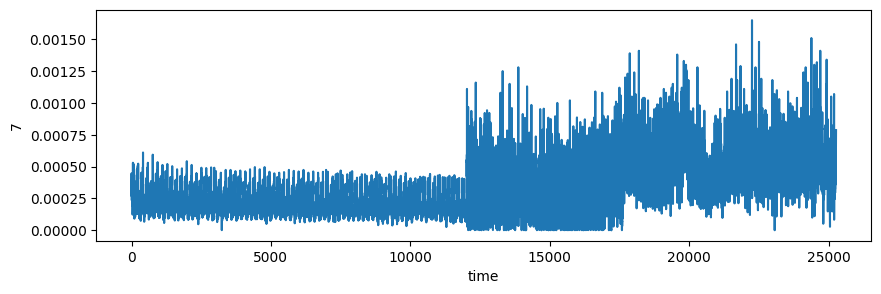

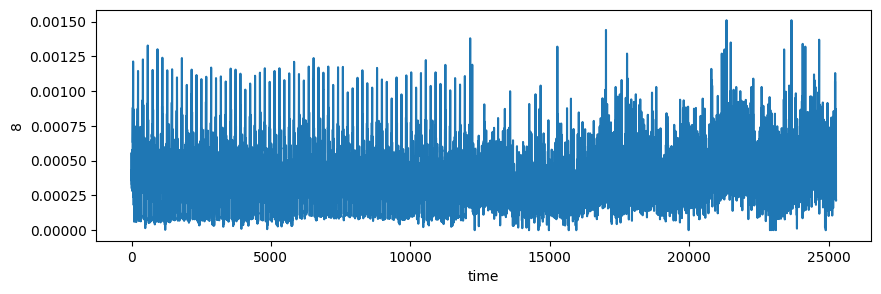

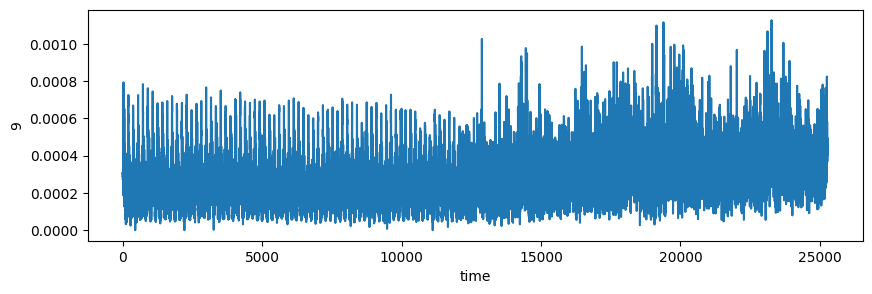

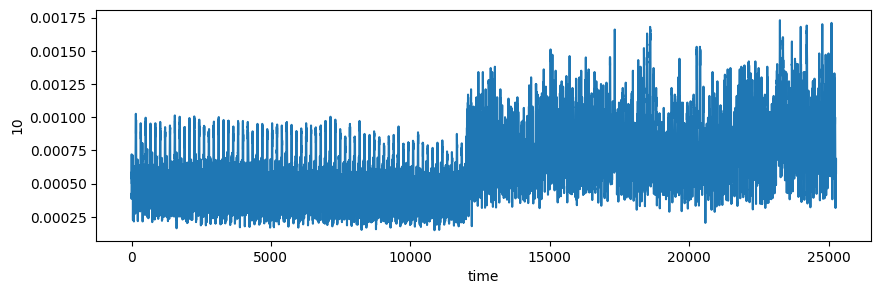

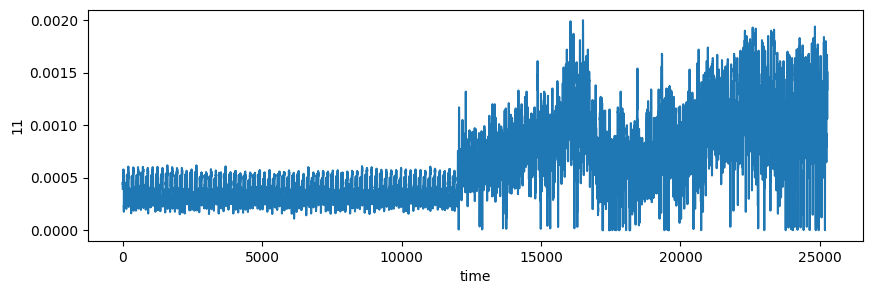

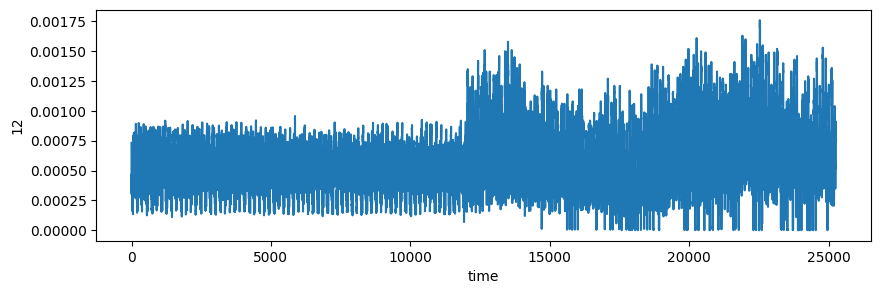

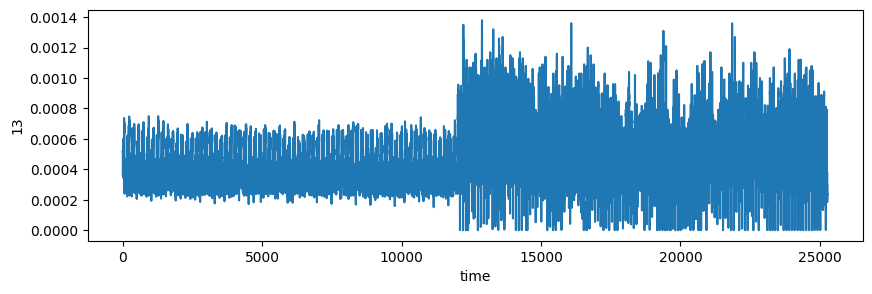

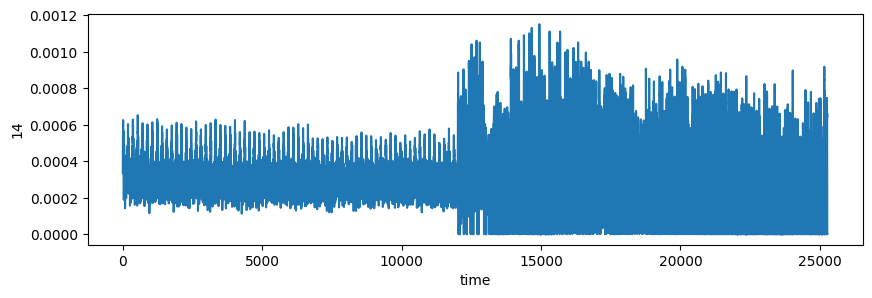

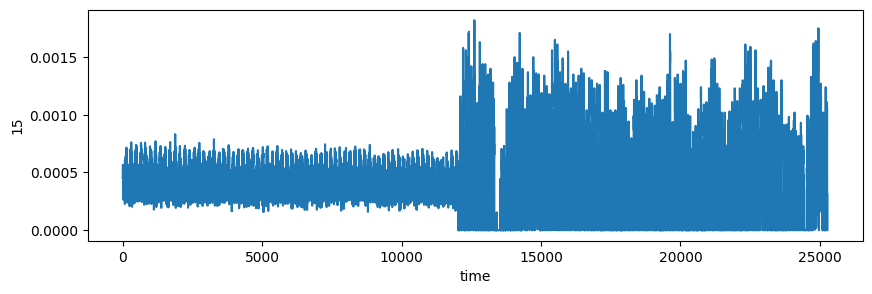

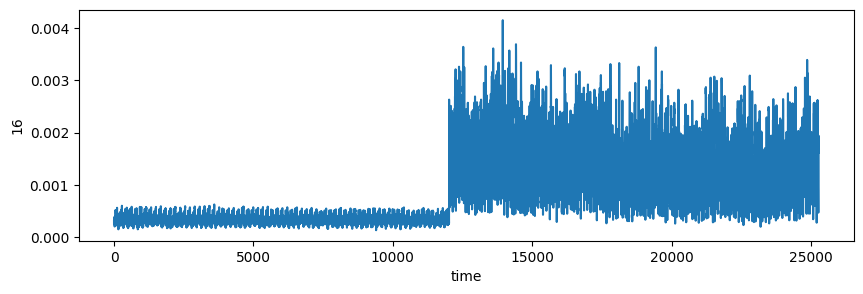

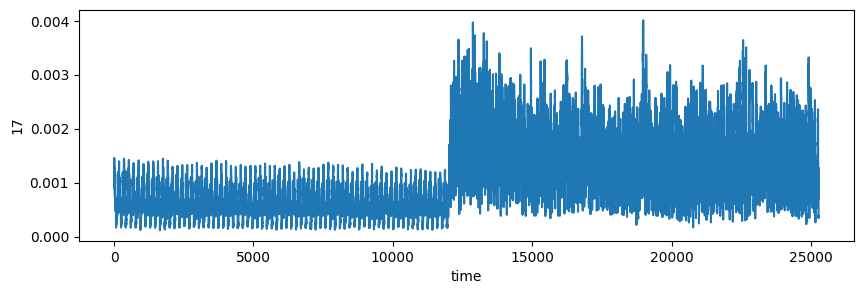

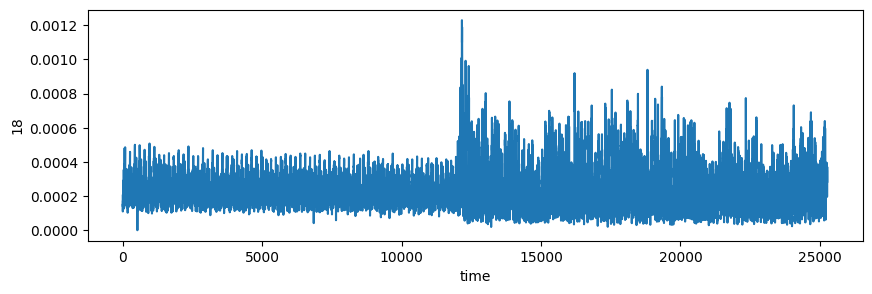

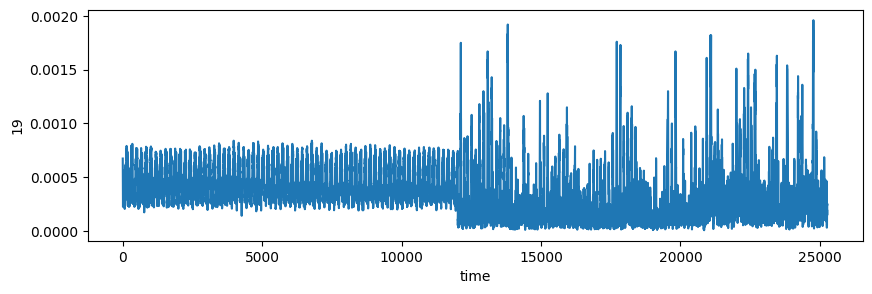

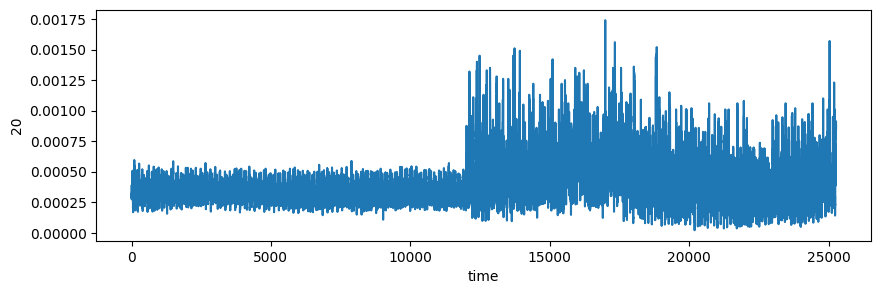

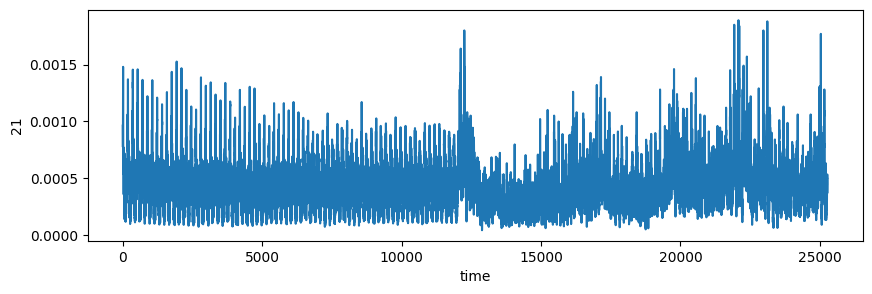

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchsummary import summary
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Helvetica']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

data = pd.read_excel(r"/kaggle/input/fabric/all.xlsx", header= None)
for i in range(data.shape[1]):
    plt.figure(figsize=(10,3))
    plt.plot(data.values[:,i])
    plt.ylabel(f"{i+1}")
    plt.xlabel("time")

# plt.show()
# 选取稳态信号
data_new  = data.iloc[1:12000,:]

# 滑窗处理数据并标准化
def get_slide_window_data(data, window_length=512, strides=16):
    # scaler = StandardScaler()
    x_data = []
    length = len(data)
    for i in range(0, length - window_length, strides):
        window_data = data[i: i + window_length].reshape(-1, 1)
        # window_data = scaler.fit_transform(window_data).reshape(-1)
        x_data.append(window_data)
    return np.array(x_data)

dataset = []
label = []
for i in range(data_new.shape[1]):
    da = data_new.iloc[:, i].values
    da = get_slide_window_data(da, 512, 2)
    dataset.extend(da)
    label.extend([i] * da.shape[0])
dataset = np.array(dataset)
label = np.array(label)
print(dataset.shape)
print(label.shape)

dataset = dataset.reshape(dataset.shape[0], 1, dataset.shape[1])
print("总数据维度为：", dataset.shape)
print("总标签维度为：", label.shape)

# 划分训练集测试集
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=2023, shuffle=True, stratify=label)
print(x_train.shape)
print(x_test.shape)

# 创建一个数据加载器
class Mydata(Dataset):
    def __init__(self, data, label):
        super().__init__()
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

train_datasets = Mydata(x_train, y_train)
test_datasets = Mydata(x_test, y_test)
train_dataloader = DataLoader(train_datasets, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=128, shuffle=True)

"""基础块"""
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.shrinkage = Shrinkage(out_channels, gap_size=(1))
        self.residual_function = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(out_channels * BasicBlock.expansion),
            self.shrinkage
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

"""收缩网络  软阈值化"""
class Shrinkage(nn.Module):
    def __init__(self, channel, gap_size):
        super(Shrinkage, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.BatchNorm1d(channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x_raw = x
        x = torch.abs(x)
        x_abs = x
        x = self.gap(x)
        x = torch.flatten(x, 1)
        average = x
        x = self.fc(x)
        x = torch.mul(average, x)
        x = x.unsqueeze(2)

        sub = x_abs - x
        zeros = sub - sub
        n_sub = torch.max(sub, zeros)
        x = torch.mul(torch.sign(x_raw), n_sub)
        return x

"""主网络框架"""
class RSNet(nn.Module):
    def __init__(self, block, num_block, num_classes=4, in_channel=1, random_seed=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channel, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True))
        self.in_channels = 16
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output_1 = output.view(output.size(0), -1)
        output_2 = self.fc(output_1)
        return output_2, output_1

model = RSNet(BasicBlock, num_block=[1, 1, 1, 1], num_classes=21, in_channel=1).to(device)
print(model)
summary(model, (1, 512))

epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# 定义训练过程
def evaluate(data_loader):
    loss_all = []
    acc_all = []
    model.eval()
    for i, (data, label) in enumerate(data_loader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)

        y_pred, _ = model(data)
        loss = criterion(y_pred, label)
        loss_all.append(loss.item())
        acc = accuracy_score(label.cpu().numpy(), np.array([np.argmax(i) for i in y_pred.detach().cpu().numpy()]))
        acc_all.append(acc)
    return np.mean(np.array(loss_all)), np.mean(np.array(acc_all))

# 训练
huitu_loss_all = []
huitu_acc_all = []
huitu_val_loss = []
huitu_val_acc = []
for epoch in range(epochs):
    loss_all = []
    acc_all = []
    model.train()
    for i, (data, label) in enumerate(train_dataloader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)

        optimizer.zero_grad()
        y_pred, _ = model(data)
        loss = criterion(y_pred, label)

        loss.backward()
        optimizer.step()

        loss_all.append(loss.item())
        acc = accuracy_score(label.cpu().numpy(), np.array([np.argmax(i) for i in y_pred.detach().cpu().numpy()]))
        acc_all.append(acc)

    loss_all = np.mean(np.array(loss_all))
    acc_all = np.mean(np.array(acc_all))
    val_loss, val_acc = evaluate(test_dataloader)
    huitu_loss_all.append(loss_all), huitu_acc_all.append(acc_all), huitu_val_loss.append(val_loss), huitu_val_acc.append(val_acc)

    print(f"epoch | epochs   {epoch}|{epochs}, loss = {loss_all:.4}   acc = {acc_all:.4}   val_loss = {val_loss:.4}   val_acc = {val_acc:.4}")
    torch.save(model.state_dict(), r'model.pth')

# 保存模型

print("模型已保存到 model.pth")







模型已加载
降维数据已保存到 tsne_data.csv


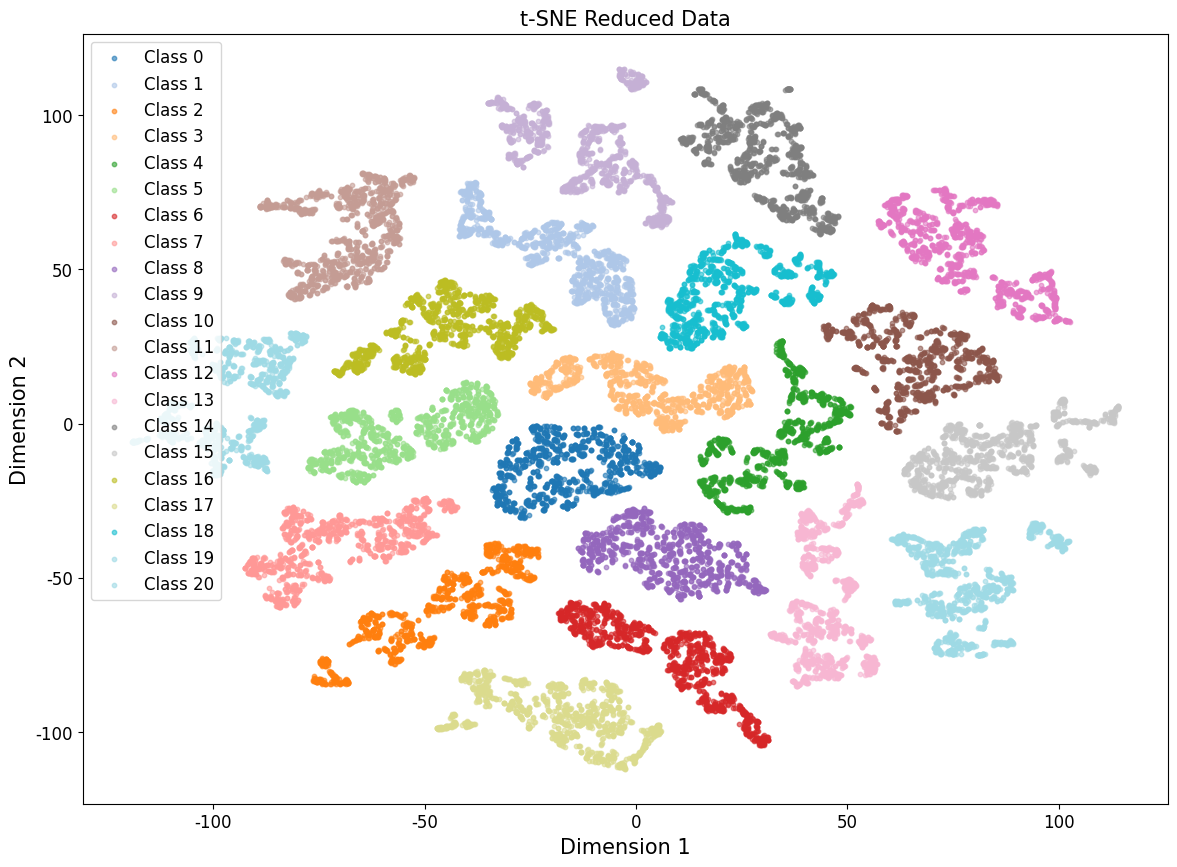

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchsummary import summary
from sklearn.metrics import confusion_matrix
device = "cuda" if torch.cuda.is_available() else "cpu"

# 加载训练好的模型
class RSNet(nn.Module):
    def __init__(self, block, num_block, num_classes=21, in_channel=1, random_seed=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channel, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True))
        self.in_channels = 16
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output_1 = output.view(output.size(0), -1)
        output_2 = self.fc(output_1)
        return output_2, output_1

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.shrinkage = Shrinkage(out_channels, gap_size=(1))
        self.residual_function = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(out_channels * BasicBlock.expansion),
            self.shrinkage
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class Shrinkage(nn.Module):
    def __init__(self, channel, gap_size):
        super(Shrinkage, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(gap_size)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel),
            nn.BatchNorm1d(channel),
            nn.ReLU(inplace=True),
            nn.Linear(channel, channel),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x_raw = x
        x = torch.abs(x)
        x_abs = x
        x = self.gap(x)
        x = torch.flatten(x, 1)
        average = x
        x = self.fc(x)
        x = torch.mul(average, x)
        x = x.unsqueeze(2)

        sub = x_abs - x
        zeros = sub - sub
        n_sub = torch.max(sub, zeros)
        x = torch.mul(torch.sign(x_raw), n_sub)
        return x

model = RSNet(BasicBlock, num_block=[1, 1, 1, 1], num_classes=21, in_channel=1).to(device)
model.load_state_dict(torch.load(r'model.pth'))
print("模型已加载")

# 定义数据集和数据加载器
class Mydata(Dataset):
    def __init__(self, data, label):
        super().__init__()
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

# 这里加载之前的数据集
data = pd.read_excel(r"/kaggle/input/fabric/all.xlsx", header=None)
data_new = data.iloc[1:12000, :]

def get_slide_window_data(data, window_length=512, strides=64):
    # scaler = StandardScaler()
    x_data = []
    length = len(data)
    for i in range(0, length - window_length, strides):
        window_data = data[i: i + window_length].reshape(-1, 1)
        # window_data = scaler.fit_transform(window_data).reshape(-1)
        x_data.append(window_data)
    return np.array(x_data)

dataset = []
label = []
for i in range(data_new.shape[1]):
    da = data_new.iloc[:, i].values
    da = get_slide_window_data(da, 512, 2)
    dataset.extend(da)
    label.extend([i] * da.shape[0])
dataset = np.array(dataset)
label = np.array(label)

dataset = dataset.reshape(dataset.shape[0], 1, dataset.shape[1])

# 划分训练集测试集
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=2023, shuffle=True, stratify=label)

train_datasets = Mydata(x_train, y_train)
test_datasets = Mydata(x_test, y_test)
train_dataloader = DataLoader(train_datasets, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=128, shuffle=True)

# 使用训练好的模型进行降维处理并保存数据
def plot_tsne_and_save(data_loader, csv_path):
    model.eval()
    label_all = []
    features_all = []
    for i, (data, label) in enumerate(data_loader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)

        _, features = model(data)
        label_all.append(label.cpu().numpy())
        features_all.append(features.detach().cpu().numpy())

    label_all = np.concatenate(label_all)
    features_all = np.concatenate(features_all)

    # 使用t-SNE降维
    tsne = TSNE(n_components=2, random_state=42)
    reduced_features = tsne.fit_transform(features_all)

    # 保存降维数据
    tsne_data = pd.DataFrame(reduced_features, columns=["Dimension 1", "Dimension 2"])
    tsne_data["Label"] = label_all
    tsne_data.to_csv(csv_path, index=False)
    print(f"降维数据已保存到 {csv_path}")

    # 绘制t-SNE降维结果
    plt.figure(figsize=(14, 10))
    colors = plt.cm.get_cmap('tab20', len(np.unique(label_all)))

    for i in np.unique(label_all):
        plt.scatter(reduced_features[label_all == i, 0], reduced_features[label_all == i, 1], alpha=0.6, s=10, color=colors(i), label=f'Class {i}', marker='o')

    plt.title('t-SNE Reduced Data', fontsize=15)
    plt.xlabel('Dimension 1', fontsize=15)
    plt.ylabel('Dimension 2', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.savefig(r"tsne_plot.png", dpi=600, format="png")
    plt.show()

csv_path = r"tsne_data.csv"
plot_tsne_and_save(test_dataloader, csv_path)
# plot_tsne_and_save(train_dataloader, csv_path)



结束